## Read the GeoTIFF DEM using GDAL

In [356]:
import os

from osgeo import gdal

dem_file_path = os.path.join(os.getcwd(), "eu_dem_v11_E40N20_wgs84.tif")
dem_raster = gdal.Open(dem_file_path)
dem_raster.GetDescription()

'/Users/vvzen/Downloads/dem/europe-copernicus/eu_dem_v11_E40N20_wgs84.tif'

### Use numpy to access the elevation data

shape: 2682x4000
max elevation value: 4778.4795
min elevation value: 0.0


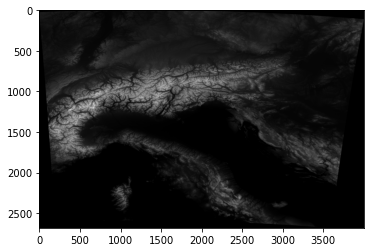

In [613]:
import numpy as np
import matplotlib.image
import matplotlib.pyplot as plt

# Luckily, GDAL offers a way to access
# the raw pixel data as a numpy array
dem_as_array = dem_raster.ReadAsArray()
print("shape: %sx%s" % dem_as_array.shape)

# We can check how the values are distributed using a histogram and the 'clim' argument of the imshow function
#plt.hist(dem_as_array.ravel(), bins=256, range=(dem_as_array.min(), dem_as_array.max()), fc='k', ec='k')
#plt.imshow(dem_as_array, cmap="gray")
# img_plot = plt.imshow(dem_as_array, clim=(0, dem_as_array.max()), cmap="gray")

# Clip negative numbers to 0
dem_as_array[dem_as_array < 0.0] = 0.0
print("max elevation value: %s" % dem_as_array.max())
print("min elevation value: %s" % dem_as_array.min())

# Show the image
plt.imshow(dem_as_array, cmap="gray")
plt.show()

# Save to disk as a lower quality 16bit png
matplotlib.image.imsave("eu_dem_v11_E40N20_wgs84.png", dem_as_array.astype(np.float16), cmap="gray")

### Sample the DEM data and visualize it

Scattered points:


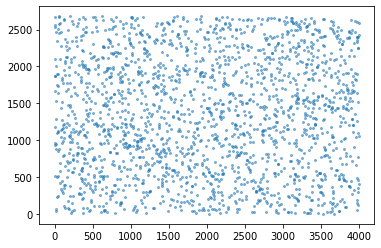

In [632]:
# This is an arbitrary number, the higher, the better (and slower)
num_samples = 2000

# For now, we sample random integers
# A more aesthetically pleasing approach would be to use a Poisson Disc Sampling
x_pos = np.random.randint(low=0, high=dem_as_array.shape[1], size=num_samples)
y_pos = np.random.randint(low=0, high=dem_as_array.shape[0], size=num_samples)

print("Scattered points:")
plt.scatter(x_pos, y_pos, s=4, alpha=0.5)
plt.show()

### Other sampling techniques

In the past I wrote a [C++ version of another sampling algo](https://gist.github.com/vvzen/3b37821d5acb9568e971d6d587b95d26#file-2d_circle_packing_mbc_2-cpp), Mitchell's Best Candidate.
Since I don't have too much time right now (and somebody else already nicely wrote a numpy version : ) ), I've grabbed the implementation described here: https://scipython.com/blog/poisson-disc-sampling-in-python/ . All credits go to the original author.

Points scattered using Poisson Disk Sampling:


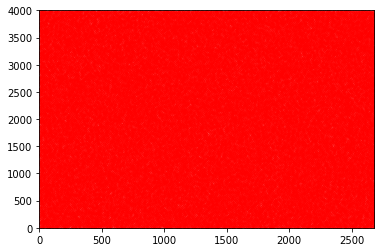

In [725]:
# Choose up to k points around each reference point
# as candidates for a new sample point
k = 16

# Minimum distance between samples
r = 10

width, height = dem_as_array.shape[0], dem_as_array.shape[1]

# Cell side length
a = r / np.sqrt(2)
# Number of cells in the x- and y-directions of the grid
nx, ny = int(width / a) + 1, int(height / a) + 1

# A list of coordinates in the grid of cells
coords_list = [(ix, iy) for ix in range(nx) for iy in range(ny)]
# Initilalize the dictionary of cells: each key is a cell's coordinates, the
# corresponding value is the index of that cell's point's coordinates in the
# samples list (or None if the cell is empty).
cells = {coords: None for coords in coords_list}

def get_cell_coords(pt):
    """Get the coordinates of the cell that pt = (x,y) falls in."""

    return int(pt[0] // a), int(pt[1] // a)

def get_neighbours(coords):
    """Return the indexes of points in cells neighbouring cell at coords.

    For the cell at coords = (x,y), return the indexes of points in the cells
    with neighbouring coordinates illustrated below: ie those cells that could 
    contain points closer than r.

                                     ooo
                                    ooooo
                                    ooXoo
                                    ooooo
                                     ooo

    """

    dxdy = [(-1,-2),(0,-2),(1,-2),(-2,-1),(-1,-1),(0,-1),(1,-1),(2,-1),
            (-2,0),(-1,0),(1,0),(2,0),(-2,1),(-1,1),(0,1),(1,1),(2,1),
            (-1,2),(0,2),(1,2),(0,0)]
    neighbours = []
    for dx, dy in dxdy:
        neighbour_coords = coords[0] + dx, coords[1] + dy
        if not (0 <= neighbour_coords[0] < nx and
                0 <= neighbour_coords[1] < ny):
            # We're off the grid: no neighbours here.
            continue
        neighbour_cell = cells[neighbour_coords]
        if neighbour_cell is not None:
            # This cell is occupied: store this index of the contained point.
            neighbours.append(neighbour_cell)
    return neighbours

def point_valid(pt):
    """Is pt a valid point to emit as a sample?

    It must be no closer than r from any other point: check the cells in its
    immediate neighbourhood.

    """

    cell_coords = get_cell_coords(pt)
    for idx in get_neighbours(cell_coords):
        nearby_pt = samples[idx]
        # Squared distance between or candidate point, pt, and this nearby_pt.
        distance2 = (nearby_pt[0]-pt[0])**2 + (nearby_pt[1]-pt[1])**2
        if distance2 < r**2:
            # The points are too close, so pt is not a candidate.
            return False
    # All points tested: if we're here, pt is valid
    return True

def get_point(k, refpt):
    """Try to find a candidate point relative to refpt to emit in the sample.

    We draw up to k points from the annulus of inner radius r, outer radius 2r
    around the reference point, refpt. If none of them are suitable (because
    they're too close to existing points in the sample), return False.
    Otherwise, return the pt.

    """
    i = 0
    while i < k:
        rho, theta = np.random.uniform(r, 2*r), np.random.uniform(0, 2*np.pi)
        pt = refpt[0] + rho*np.cos(theta), refpt[1] + rho*np.sin(theta)
        if not (0 <= pt[0] < width and 0 <= pt[1] < height):
            # This point falls outside the domain, so try again.
            continue
        if point_valid(pt):
            return pt
        i += 1
    # We failed to find a suitable point in the vicinity of refpt.
    return False

# Pick a random point to start with.
pt = (np.random.uniform(0, width), np.random.uniform(0, height))
samples = [pt]
# Our first sample is indexed at 0 in the samples list...
cells[get_cell_coords(pt)] = 0
# ... and it is active, in the sense that we're going to look for more points
# in its neighbourhood.
active = [0]

nsamples = 1
# As long as there are points in the active list, keep trying to find samples.
while active:
    # choose a random "reference" point from the active list.
    idx = np.random.choice(active)
    refpt = samples[idx]
    # Try to pick a new point relative to the reference point.
    pt = get_point(k, refpt)
    if pt:
        # Point pt is valid: add it to the samples list and mark it as active
        samples.append(pt)
        nsamples += 1
        active.append(len(samples)-1)
        cells[get_cell_coords(pt)] = len(samples) - 1
    else:
        # We had to give up looking for valid points near refpt, so remove it
        # from the list of "active" points.
        active.remove(idx)
    
    # My (vvzen) addition: we don't want to sample
    # more points than data available in the DEM
    if nsamples > width * height:
        break

pds_points = np.array(samples)
pds_x_pos, pds_y_pos = np.hsplit(pds_points, 2)
        
plt.scatter(pds_x_pos, pds_y_pos, color='r', s=4, alpha=0.4)
plt.xlim(0, width)
plt.ylim(0, height)

print("Points scattered using Poisson Disk Sampling:")
plt.show()

### Sample the elevation data using the X,Y coords that we've generated

Shapes of the separate arrays: x_pos: (65090,), y_pos: (65090,), z_pos: (65090,)
Shape of new 'points' array: 65090x3


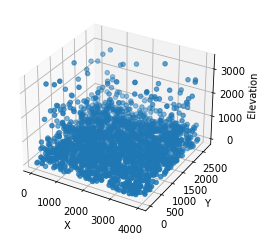

2572.0 1044.0 0.0


In [726]:
# Let's collect the 3 arrays in a single one
x_positions = pds_x_pos.astype(int).flatten()
y_positions = pds_y_pos.astype(int).flatten()
z_positions = np.zeros((np.array([y_positions]).size))

print("Shapes of the separate arrays: x_pos: %s, y_pos: %s, z_pos: %s" % (x_positions.shape, y_positions.shape, z_positions.shape))

# Sample the depth from the source dem array at that x,y coordinate
for i in range(z_positions.size):
        
    x,y = x_positions[i], y_positions[i]
        
    z_positions[i] = dem_as_array[x, y]

points = np.stack([x_positions, y_positions, z_positions], axis=1)

print("Shape of new 'points' array: %sx%s" % (points.shape))
    
axis = plt.axes(projection="3d")
axis.set_xlabel('X')
axis.set_ylabel('Y')
axis.set_zlabel('Elevation')
axis.scatter3D(x_pos, y_pos, z_pos, cmap="gray")


# We could even triangulate the points if we want,
# leveraging scipy built-in classes
#from scipy.spatial import Delaunay
#tri = Delaunay(points)

plt.show()

for point in points:
    x, y, z = point
    print("%s %s %s" % (x, y, z))
    break

### Finally, let's write out a simple ASCII PLY file

In [727]:
import textwrap

PLY_HEADER = textwrap.dedent("""ply
format ascii 1.0
comment export ply from pts using python (by vvz3n)
element vertex {total_vertices}
comment {comment}
property float x
property float y
property float z
end_header
""")

def write_numpy_points_array_to_ply(points, output_path):
    
    print("Starting to write file to %s .." % output_path)
    
    with open(output_path, "w") as f:
        header = PLY_HEADER.format(total_vertices=points.shape[0], comment="ply generated from python code")
        f.write(header)
        for point in points:
            x, y, z = point
            line = "{x} {y} {z}\n".format(x=float(x), y=z, z=float(y))
            f.write(line)
                
    print("..finished writing!")
    
# Let's write everything out as a simple ply point cloud
out_file_name = os.path.basename(dem_file_path).lower().replace(".tif", ".ply")
ply_path = os.path.join(os.path.dirname(dem_file_path), out_file_name)
write_numpy_points_array_to_ply(points, ply_path)

Starting to write file to /Users/vvzen/Downloads/dem/europe-copernicus/eu_dem_v11_e40n20_wgs84.ply ..
..finished writing!
